# EDA CHUYÊN SÂU TRÊN CÁC ĐẠI DIỆN 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from sklearn.ensemble import IsolationForest
import matplotlib.dates as mdates

## Chuẩn bị dữ liệu cho các Quốc gia Đại diện
Trước tiên, ta lọc dữ liệu chỉ lấy các quốc gia đại diện mà bạn đã chọn từ kết quả phân cụm (USA, India, Israel, Yemen, Sweden).

In [2]:
df_1 = pd.read_csv('../data/processed/01_clean_daily_timeseries.csv.gz')

In [3]:
rep_countries = {
    'United States of America': 0, 
    'India': 1, 
    'Israel': 2, 
    'Yemen': 3, 
    'Sweden': 4
}

# LỌC DỮ LIỆU TỪ df_1 (TIME SERIES)
df_1['Date_reported'] = pd.to_datetime(df_1['Date_reported'])

# Lấy dữ liệu của các nước đại diện
df_rep = df_1[df_1['Country'].isin(rep_countries)].copy()

print(f"Đã lọc dữ liệu cho {len(rep_countries)} quốc gia đại diện.")
print(df_rep['Country'].unique())

Đã lọc dữ liệu cho 5 quốc gia đại diện.
['India' 'Israel' 'Sweden' 'United States of America' 'Yemen']


## 4.3.1. Phân tích Chuỗi thời gian chi tiết


### 4.3.1.1. Hình thái và các đợt bùng phát
Phần này vẽ biểu đồ so sánh và dùng thuật toán find_peaks của scipy để đếm số lượng làn sóng dịch (Waves) một cách tự động thay vì đếm bằng mắt.

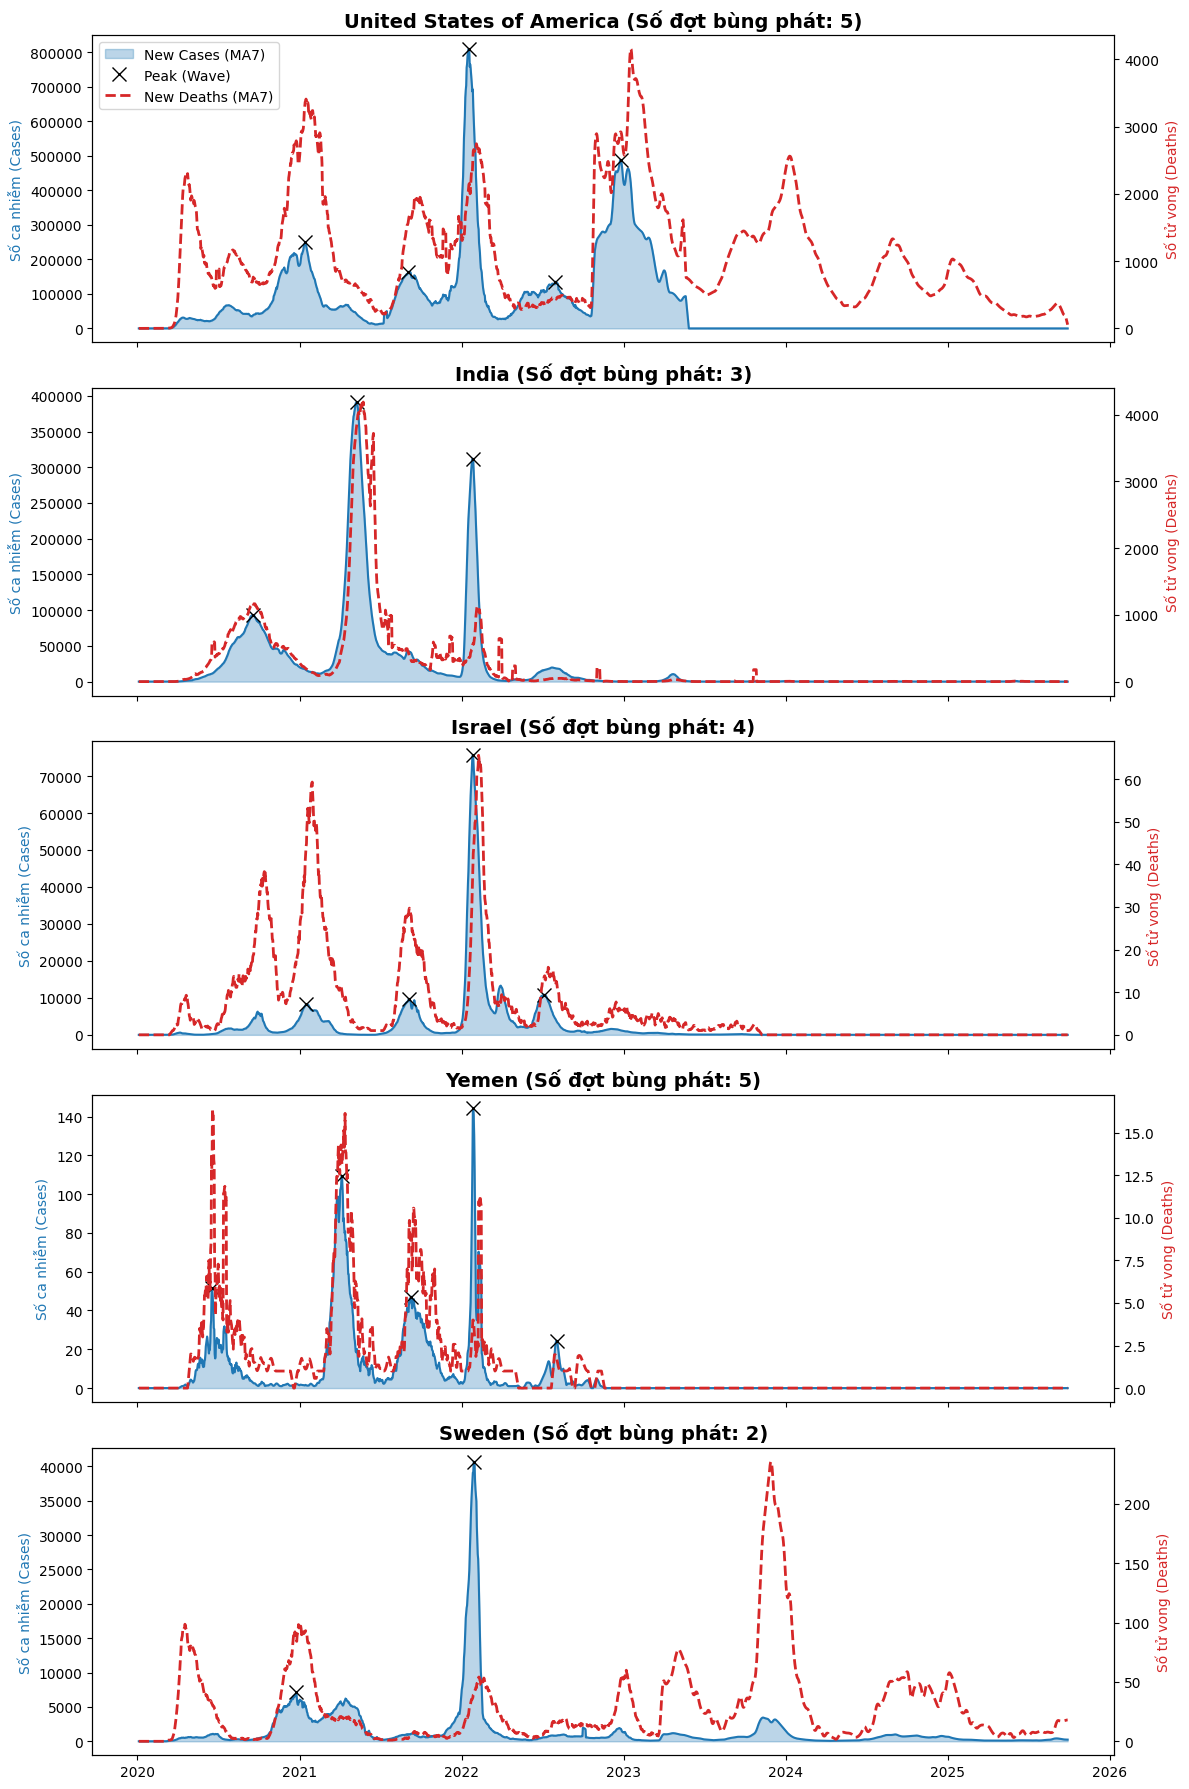

Số lượng đợt bùng phát (Waves) phát hiện được: {'United States of America': 5, 'India': 3, 'Israel': 4, 'Yemen': 5, 'Sweden': 2}


In [4]:
fig, axes = plt.subplots(len(rep_countries), 1, figsize=(12, 18), sharex=True)

# Tạo dictionary để lưu số lượng wave tìm được
wave_counts = {}

for i, country in enumerate(rep_countries):
    data = df_rep[df_rep['Country'] == country].sort_values('Date_reported')
    y_cases = data['New_cases_MA7'].fillna(0).values
    y_deaths = data['New_deaths_MA7'].fillna(0).values
    x_dates = data['Date_reported'].values
    
    # 1. Vẽ biểu đồ
    ax1 = axes[i]
    ax2 = ax1.twinx() # Trục y thứ 2 cho tử vong
    
    # Vẽ Ca nhiễm
    ax1.fill_between(x_dates, y_cases, color='tab:blue', alpha=0.3, label='New Cases (MA7)')
    ax1.plot(x_dates, y_cases, color='tab:blue', linewidth=1.5)
    
    # Vẽ Tử vong
    ax2.plot(x_dates, y_deaths, color='tab:red', linewidth=2, linestyle='--', label='New Deaths (MA7)')
    
    # 2. Thuật toán tìm đỉnh (Peak Detection)
    # distance=60: Các đỉnh phải cách nhau ít nhất 60 ngày (tránh đỉnh nhiễu)
    # prominence: Độ nổi bật của đỉnh so với xung quanh
    peaks, _ = find_peaks(y_cases, distance=60, prominence=np.max(y_cases)*0.1)
    
    # Đánh dấu đỉnh lên biểu đồ
    ax1.plot(x_dates[peaks], y_cases[peaks], "x", color='black', markersize=10, label='Peak (Wave)')
    
    # Lưu số lượng wave
    wave_counts[country] = len(peaks)
    
    # Trang trí
    ax1.set_title(f'{country} (Số đợt bùng phát: {len(peaks)})', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Số ca nhiễm (Cases)', color='tab:blue')
    ax2.set_ylabel('Số tử vong (Deaths)', color='tab:red')
    
    if i == 0: # Chỉ hiện legend ở hình đầu tiên cho đỡ rối
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xlabel('Thời gian')
plt.tight_layout()
plt.savefig("../results/charts/num_waves.png")
plt.show()

print("Số lượng đợt bùng phát (Waves) phát hiện được:", wave_counts)

Quan sát biểu đồ chuỗi thời gian ca nhiễm (vùng màu xanh) và tử vong (đường nét đứt màu đỏ) của 5 quốc gia đại diện, ta nhận thấy sự phân hóa rõ rệt về **hình thái sóng (Wave Morphology)** và **mối tương quan nhiễm - tử vong**:

**1. Hoa Kỳ (Cluster 0 - Tâm dịch dai dẳng)**

* Số lượng sóng: Thuật toán phát hiện 5 đợt bùng phát lớn.

* Hình thái: Các đợt sóng nối tiếp nhau liên tục với biên độ rất lớn (đỉnh dịch lên tới 800.000 ca/ngày). Điều này phản ánh đặc điểm của một quốc gia có quy mô dân số lớn và sự lây lan dịch bệnh diễn ra trên diện rộng, kéo dài qua nhiều năm mà không có giai đoạn "nghỉ" rõ rệt.

* Tương quan: Đường tử vong bám sát đường ca nhiễm trong các làn sóng đầu, nhưng biên độ thấp hơn hẳn ở các làn sóng sau (năm 2022 trở đi), cho thấy hiệu quả của miễn dịch cộng đồng và vắc-xin.

**2. Ấn Độ (Cluster 1 - Bùng nổ cường độ cao)**

* Số lượng sóng: Phát hiện 3 đợt bùng phát.

* Hình thái: Khác với Mỹ, đồ thị của Ấn Độ có dạng "Khoảng lặng - Bùng nổ". Điển hình là đợt sóng thứ 2 (khoảng giữa năm 2021 - biến chủng Delta) tạo thành một đỉnh nhọn cực đại, cao gấp nhiều lần so với đợt 1, sau đó giảm rất nhanh.

* Nhận định: Đây là hình thái đặc trưng của các quốc gia đang phát triển có mật độ dân số dày đặc: Khi dịch bùng phát sẽ tạo ra áp lực cực lớn trong thời gian ngắn (Shock), sau đó đạt đỉnh và suy giảm nhanh.

**3. Israel (Cluster 2 - Chu kỳ lặp lại & Hiệu quả Vắc-xin)**

* Số lượng sóng: Phát hiện 4 đợt bùng phát.

* Hình thái: Các đợt sóng xuất hiện đều đặn với tần suất dày đặc.

* Điểm đặc biệt (Quan trọng): Hãy quan sát sự "tách rời" (decoupling) giữa Ca nhiễm và Tử vong.

   * Ở các làn sóng đầu (2020), đường màu đỏ (tử vong) tăng rất cao cùng với ca nhiễm.
   
   * Ở làn sóng lớn nhất (2022 - biến chủng Omicron), dù cột màu xanh dựng đứng (số ca nhiễm kỷ lục), nhưng đường màu đỏ lại nằm rất thấp.
   
   * $\rightarrow$ Đây là bằng chứng trực quan nhất cho Cụm 2 (Cluster 2): Các quốc gia kiểm soát tốt tử vong nhờ chiến dịch tiêm chủng thần tốc.
   
**4. Yemen (Cluster 3 - Dữ liệu bất thường/Ngoại lệ)**

* Số lượng sóng: Máy đếm được 5 đỉnh, nhưng hãy nhìn vào trục tung (Y-axis).

* Hình thái: Số ca nhiễm cực thấp (chỉ khoảng 140 ca/ngày ở đỉnh), đường biểu diễn bị đứt đoạn và nhiễu.

* Tương quan (Rất quan trọng): Đường màu đỏ (Tử vong) gần như trùng khít hoặc cao ngang ngửa với vùng màu xanh (Ca nhiễm).

   * Điều này giải thích tại sao Yemen có CFR lên tới 18% trong bảng đặc trưng. Do thiếu năng lực xét nghiệm, họ chỉ ghi nhận những ca bệnh rất nặng (sắp tử vong), bỏ qua hầu hết các ca nhiễm nhẹ trong cộng đồng. Đây là mô hình "Tảng băng chìm".
   
**5. Thụy Điển (Cluster 4 - Mô hình khác biệt)**

* Số lượng sóng: Chỉ phát hiện 2 đợt bùng phát lớn rõ rệt theo thuật toán.

* Hình thái: Khác với các nước Châu Âu khác thường có nhiều đỉnh nhỏ, Thụy Điển có một đỉnh cực lớn vào năm 2022. Giai đoạn đầu (2020-2021), số ca nhiễm (vùng xanh) trông có vẻ thấp nhưng đường tử vong (nét đứt đỏ) lại khá cao.

* Nhận định: Điều này phản ánh chính sách "Không phong tỏa" (No Lockdown) gây tranh cãi ban đầu, dẫn đến tỷ lệ tử vong cao trong giai đoạn đầu dịch dù số ca nhiễm ghi nhận không quá đột biến (do ít xét nghiệm đại trà thời điểm đó).

### 4.3.1.2. Phân tích cấu trúc và tính dừng

#### a. Phân rã chuỗi thời gian (DECOMPOSITION)

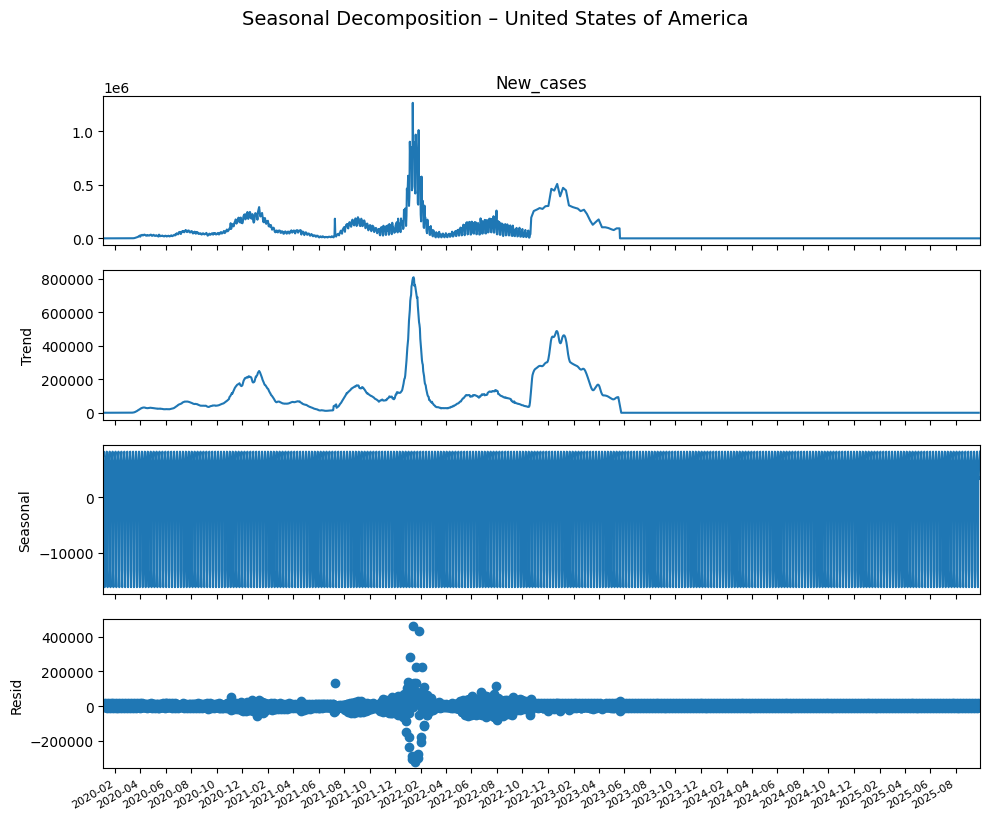

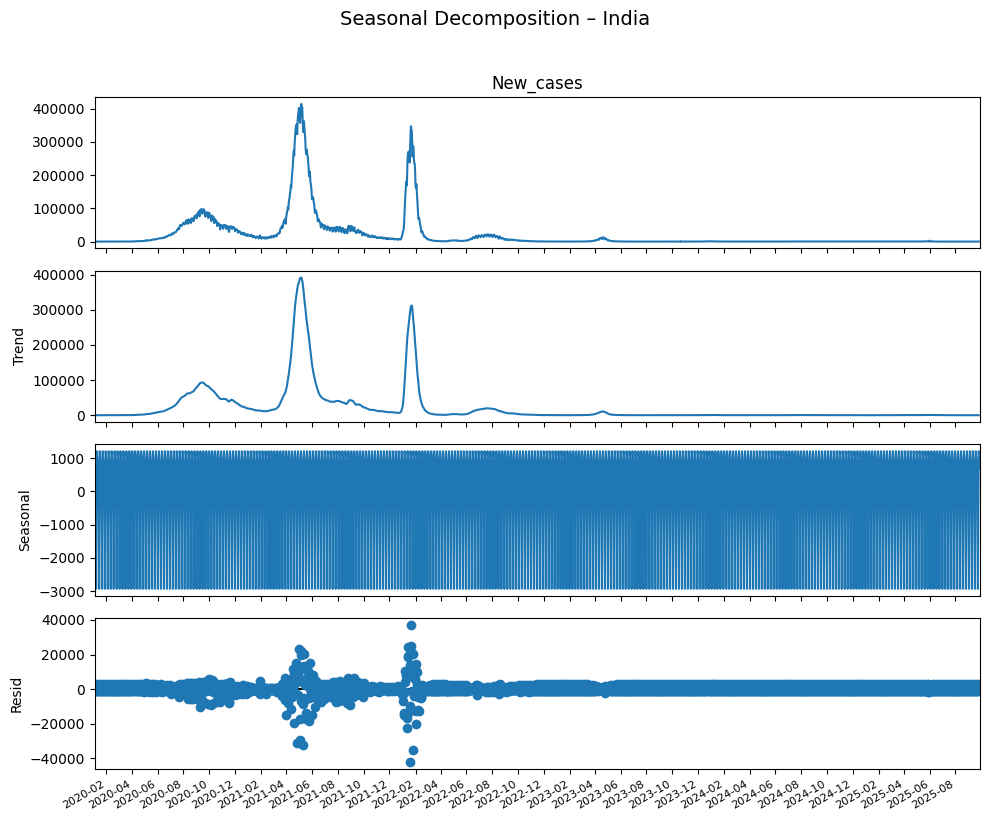

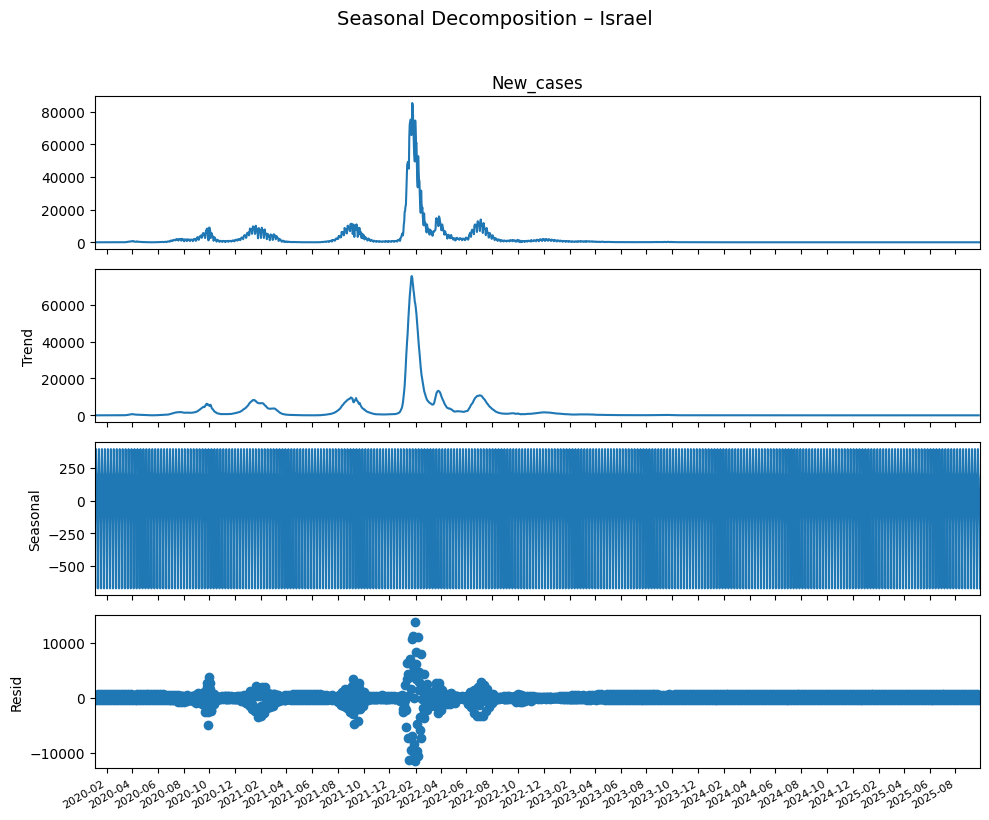

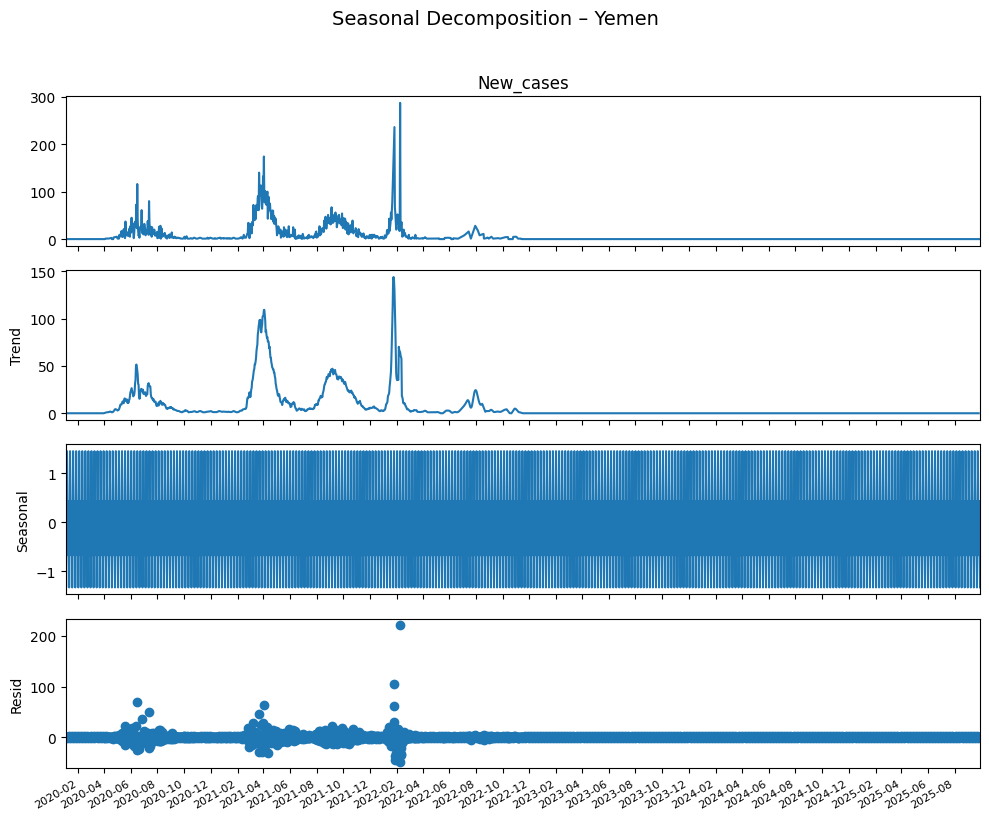

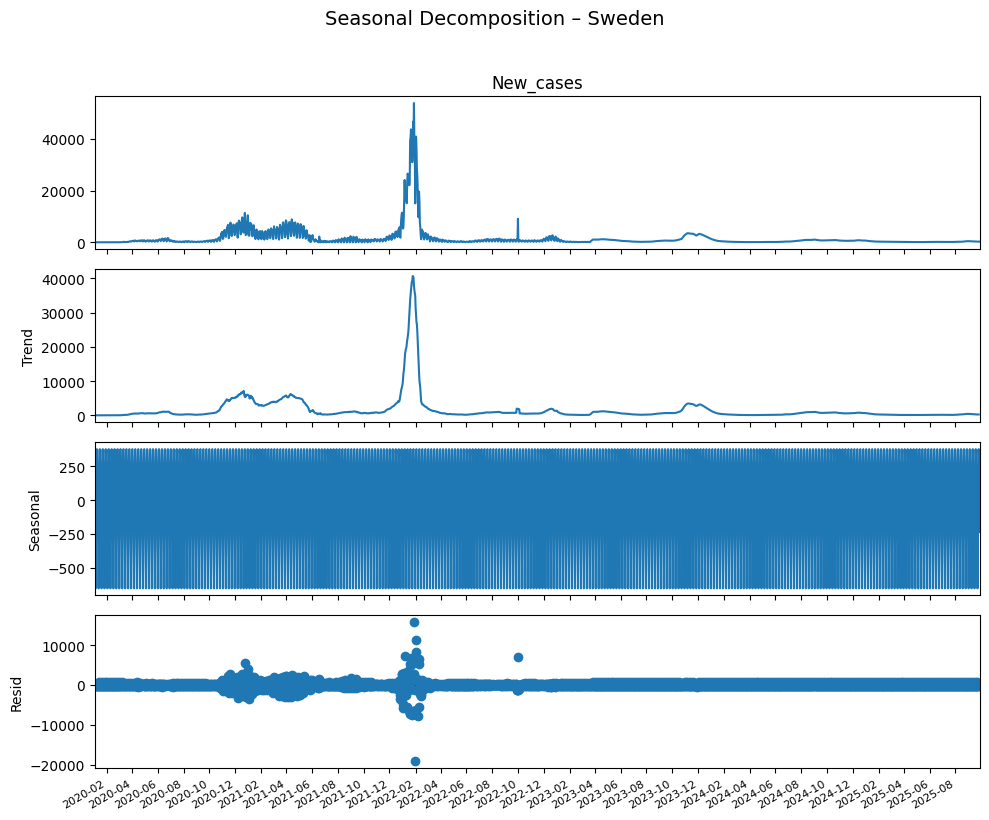

In [5]:
import matplotlib.dates as mdates
for c in rep_countries:
    # Lọc dữ liệu
    sub = df_rep[df_rep["Country"] == c].set_index("Date_reported")

    series = sub["New_cases"].fillna(0) 

    result = seasonal_decompose(series, model="additive", period=7)

    fig = result.plot()
    
    fig.set_size_inches(10, 8)

    plt.suptitle(f"Seasonal Decomposition – {c}", fontsize=14, y=1.02)

    for ax in fig.axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', labelsize=8)

    fig.autofmt_xdate()

    plt.tight_layout()
  
    safe_name = c.replace(' ', '_').lower()
    plt.savefig(f"../results/charts/seasonal_decomposition_covid19_{safe_name}.png", bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

#### b. Kiểm định tính dừng (ADF TEST)

In [6]:
from statsmodels.tsa.stattools import adfuller

for c in rep_countries:
    print(f"\n=== KẾT QUẢ KIỂM ĐỊNH ADF ({c}) ===")
    sub = df_rep[df_rep["Country"] == c].set_index("Date_reported")

    series = sub["Cumulative_cases"].fillna(0) 
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] > 0.05:
        print("=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.")
    else:
        print("=> KẾT LUẬN: Chuỗi DỪNG (Stationary).")


=== KẾT QUẢ KIỂM ĐỊNH ADF (United States of America) ===
ADF Statistic: -2.0807
p-value: 0.2523
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (India) ===
ADF Statistic: -2.3261
p-value: 0.1637
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (Israel) ===
ADF Statistic: -1.5002
p-value: 0.5334
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (Yemen) ===
ADF Statistic: -2.7755
p-value: 0.0619
Critical Values:
	1%: -3.4335
	5%: -2.8629
	10%: -2.5675
=> KẾT LUẬN: Chuỗi KHÔNG DỪNG (Non-stationary). Cần lấy sai phân trước khi dự báo.

=== KẾT QUẢ KIỂM ĐỊNH ADF (Sweden) ===
ADF Statistic: -1.8334
p-value: 0.3640
Critical Values:
	1%: -3.4335

#### c. Biểu đồ tự tương quan (ACF & PACF)

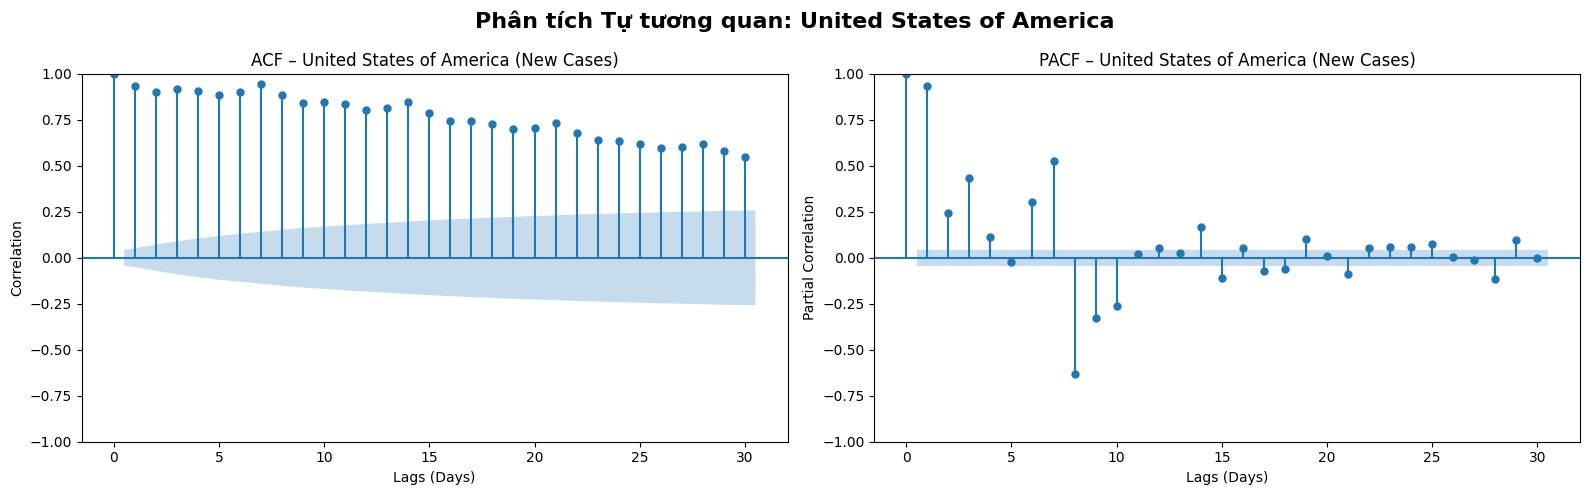

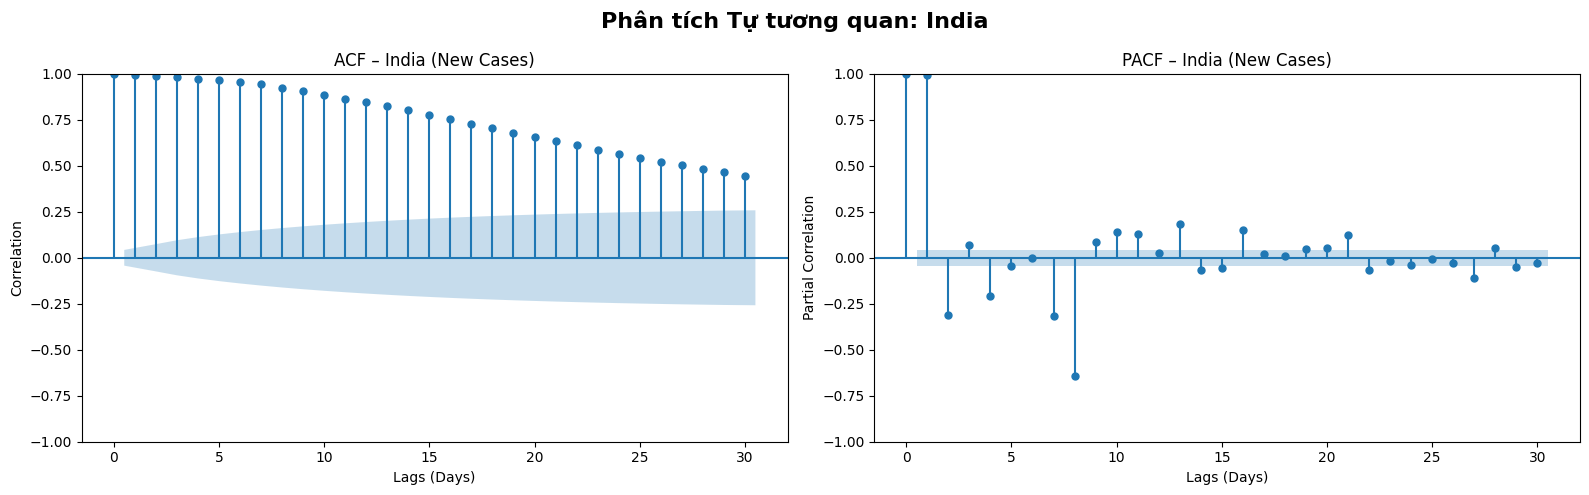

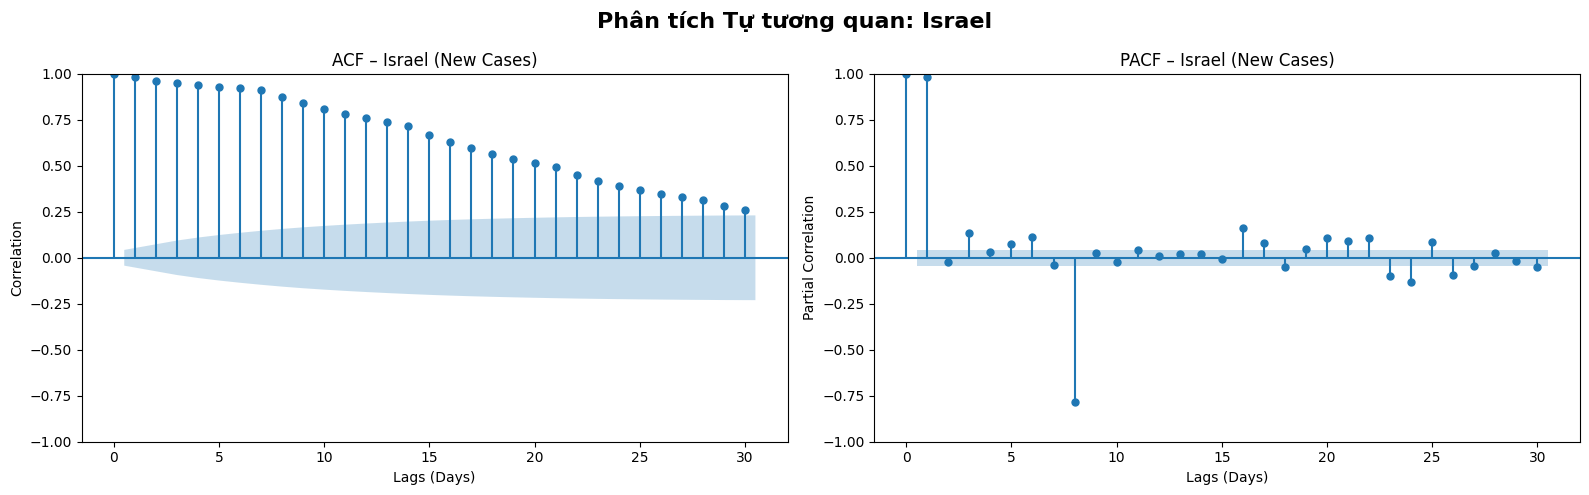

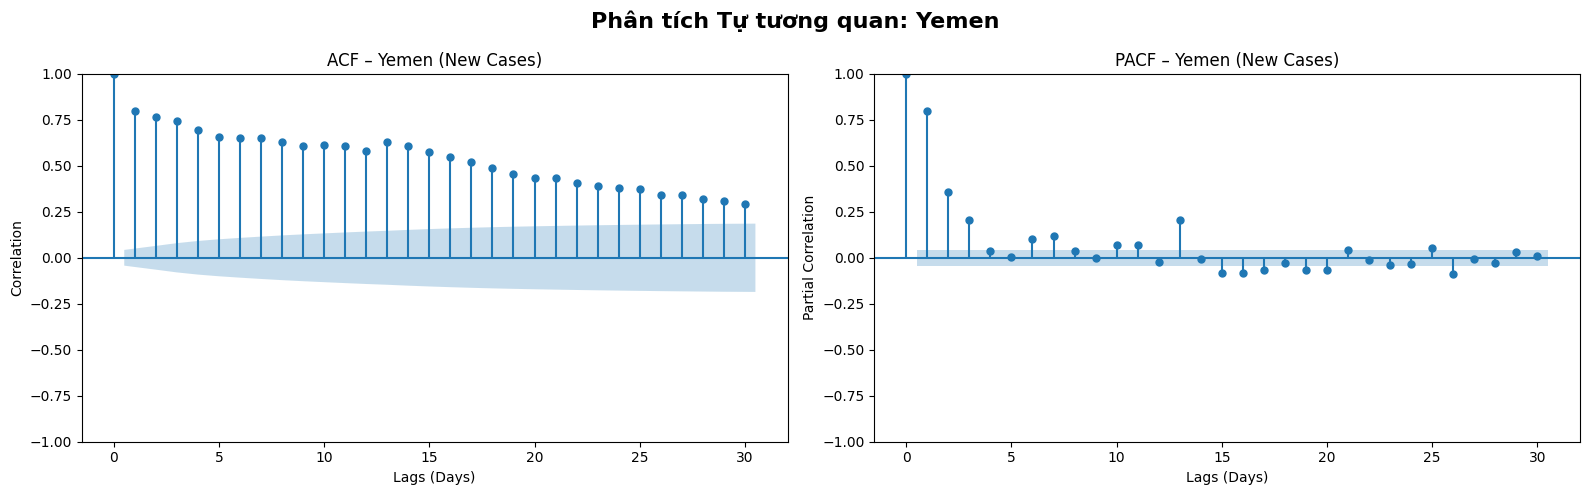

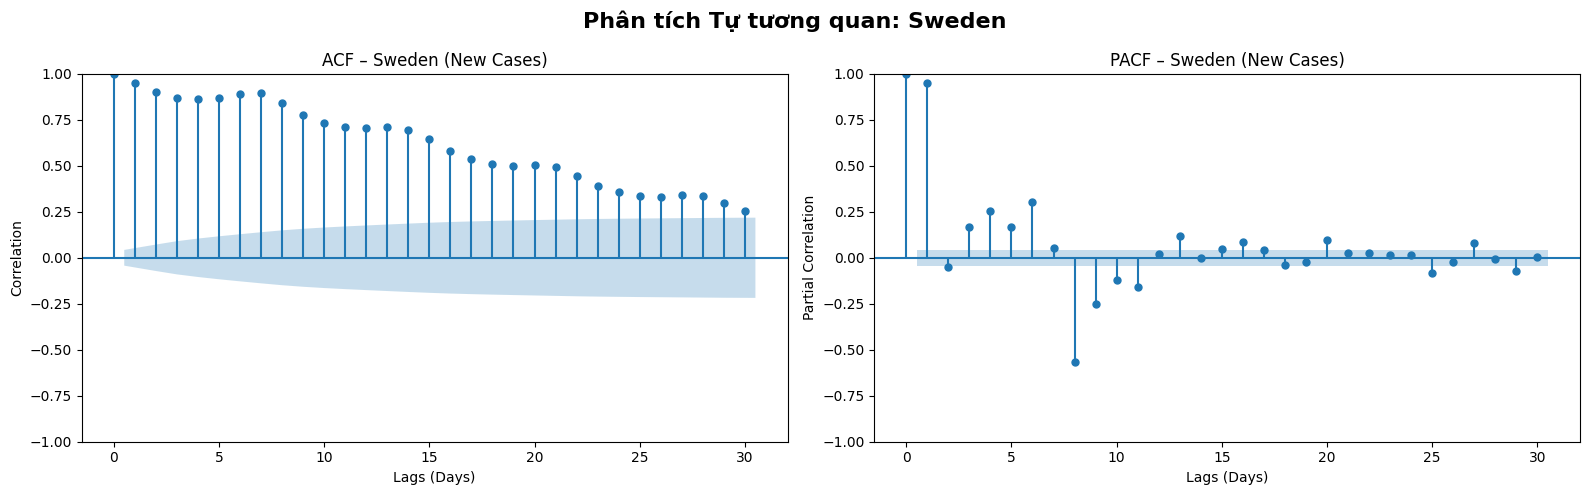

In [7]:
for c in rep_countries:
    
    sub = df_rep[df_rep["Country"] == c]["New_cases"].fillna(0)
    
    # Kiểm tra nếu dữ liệu quá ít thì bỏ qua để tránh lỗi
    if len(sub) < 30:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Vẽ ACF bên trái
    plot_acf(sub, lags=30, ax=axes[0], title=f"ACF – {c} (New Cases)")
    axes[0].set_xlabel('Lags (Days)')
    axes[0].set_ylabel('Correlation')

    # Vẽ PACF bên phải
    plot_pacf(sub, lags=30, method="ywm", ax=axes[1], title=f"PACF – {c} (New Cases)")
    axes[1].set_xlabel('Lags (Days)')
    axes[1].set_ylabel('Partial Correlation')

    plt.suptitle(f"Phân tích Tự tương quan: {c}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Lưu file
    filename = f"../results/charts/acf_pacf_{c.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

Quan sát tổng quan cả 5 quốc gia, ta nhận thấy một mô hình chung (Pattern) rất đặc trưng của dữ liệu chuỗi thời gian dịch tễ:

1. **Tính Tự hồi quy mạnh (Strong Autoregression):**

* **Biểu đồ ACF**: Tại tất cả các quốc gia, hệ số tự tương quan khởi đầu rất cao (gần 1.0) và giảm dần rất chậm (tailing off) theo dạng hình học hoặc tuyến tính. Điều này cho thấy dữ liệu có "trí nhớ dài hạn" (long memory) – số ca nhiễm hôm nay bị ảnh hưởng mạnh bởi chuỗi ca nhiễm của nhiều ngày trước đó.

* **Biểu đồ PACF**: Có một gai (spike) rất lớn tại `Lag 1` (gần bằng 1) và sau đó giảm mạnh hoặc dao động quanh 0. Đây là dấu hiệu sách giáo khoa của một quá trình Tự hồi quy (AR - AutoRegressive).

2. **Dấu hiệu Mùa vụ (Seasonality):**

* Tại biểu đồ PACF của một số quốc gia (đặc biệt là Sweden và Israel), xuất hiện các gai bất thường tại Lag 7, Lag 8 hoặc Lag 14. Đây là minh chứng rõ ràng cho tính chu kỳ tuần (Weekly Seasonality) do quy trình báo cáo số liệu (thường giảm vào cuối tuần và tăng vọt vào đầu tuần).

**CHI TIẾT TỪNG QUỐC GIA**

1. **United States of America (USA)**

* ACF: Giảm dần đều đặn, tất cả các lag từ 1-30 đều vượt ngưỡng ý nghĩa (vùng xanh nhạt). Điều này xác nhận xu hướng (Trend) mạnh trong dữ liệu.

* PACF: Gai lớn nhất tại Lag 1 (~0.9), gai thứ hai tại Lag 2 (~0.4) và Lag 3.

2. **Israel**

* ACF: Giảm chậm tương tự Mỹ.

* PACF: Sau Lag 1 rất cao, ta thấy các gai âm đáng chú ý quanh Lag 7 và Lag 8.

* Kết luận: Dữ liệu của Israel chịu ảnh hưởng bởi tính mùa vụ tuần. Khi xây dựng mô hình, cần thêm đặc trưng lag_7 để bắt được quy luật này.

3. **Yemen**

* ACF: Mặc dù cũng giảm dần, nhưng độ dốc giảm nhanh hơn so với Mỹ hay Ấn Độ.

* PACF: Lag 1 dương (~0.8), nhưng Lag 2 cũng dương khá cao (~0.3). Các lag sau đó (3, 4, 5) dao động yếu.

* Kết luận: Dữ liệu Yemen có vẻ "nhiễu" hơn (ít mượt mà hơn), phản ánh đúng thực tế dữ liệu thiếu ổn định của cụm này (Cluster 3).

4. **India**
* ACF: Đường ACF giảm rất chậm, gần như một đường thẳng đi xuống. Đây là dấu hiệu cho thấy chuỗi dữ liệu có quán tính rất lớn.

* PACF: Gai Lag 1 xấp xỉ 1.0. Đặc biệt, Lag 2 có giá trị âm. Hiện tượng "Lag 1 dương cực lớn, Lag 2 âm" thường ám chỉ một sự "điều chỉnh quá mức" (over-correction) trong chuỗi dữ liệu, hoặc dữ liệu đã được làm trơn (Smoothing) quá kỹ.

5. **Sweden (Thụy Điển) - Trường hợp đặc biệt nhất**

* ACF: Tương tự các nước khác.

* PACF: Đây là biểu đồ thú vị nhất.

    * Lag 1 rất cao.

    * Lag 8 xuất hiện một gai ÂM cực lớn (gần -0.6).

    * Gai tại Lag 8 (tức là 7 + 1) là dấu hiệu cực mạnh của tính mùa vụ tuần bị lệch pha.

* Kết luận: Thụy Điển có quy trình báo cáo cuối tuần rất khác biệt (thường không báo cáo T7-CN và cộng dồn vào T3), tạo ra cú sốc thống kê định kỳ. Mô hình dự báo bắt buộc phải xử lý yếu tố Seasonality = 7 nếu không sai số sẽ rất lớn.

**KẾT LUẬN**

* Chọn biến Lag_1 là quan trọng nhất (do PACF Lag 1 luôn cao nhất)

* Xử lý Mùa vụ: Bắt buộc phải đưa biến lag_7 để xử lý tính chu kỳ tuần.

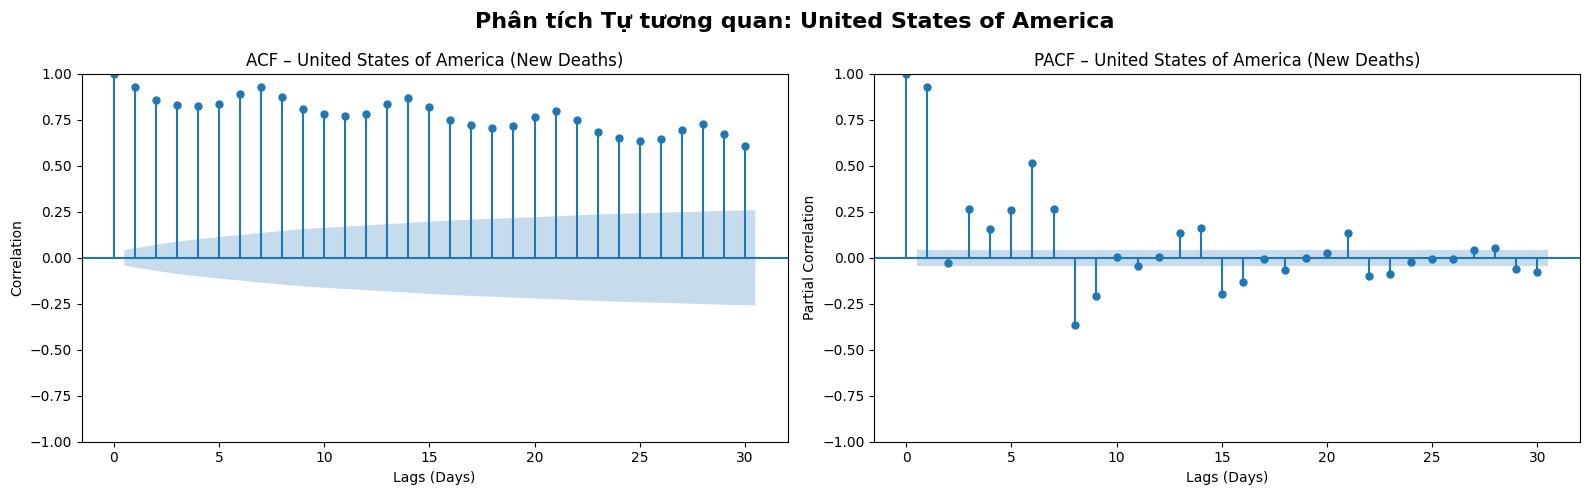

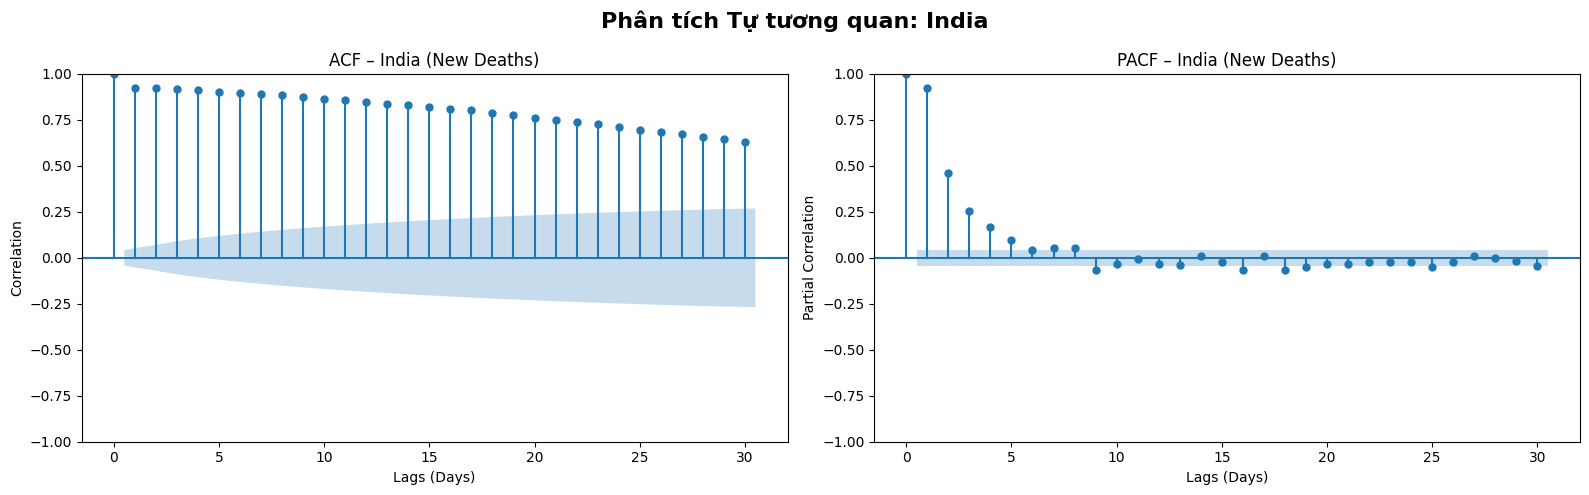

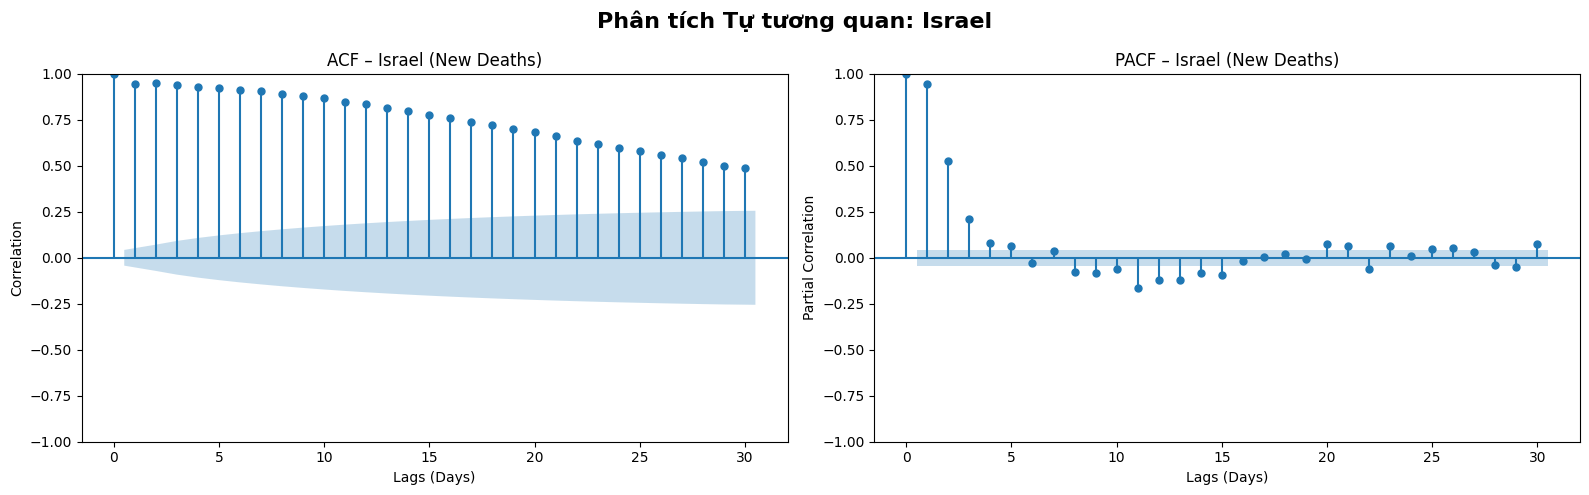

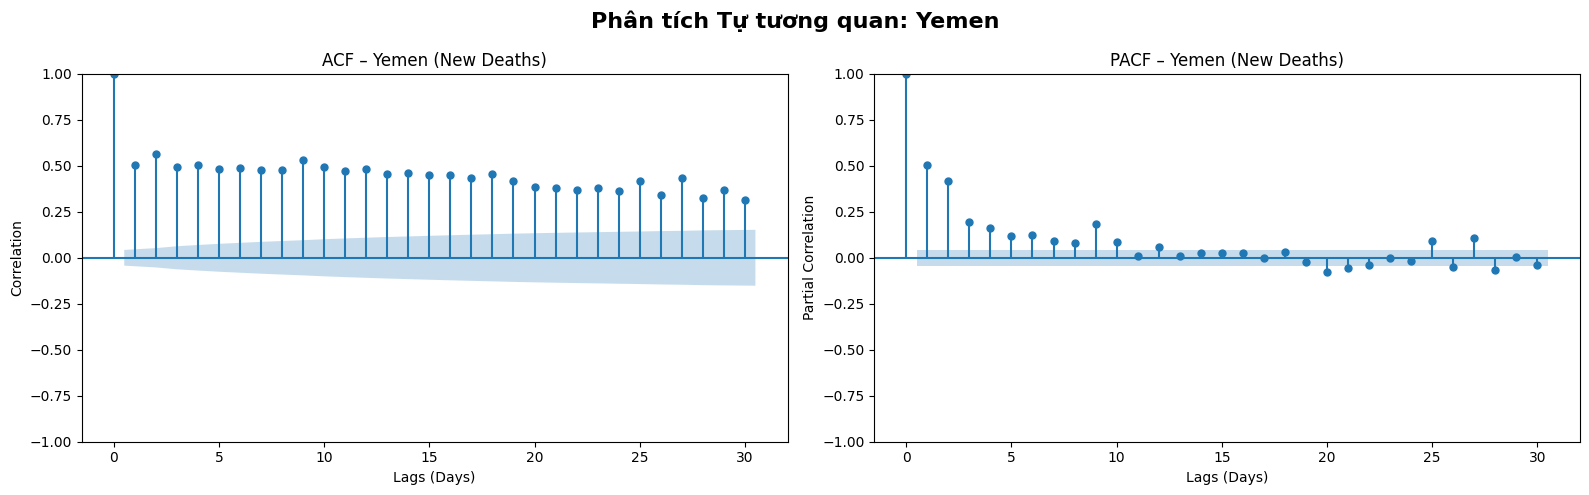

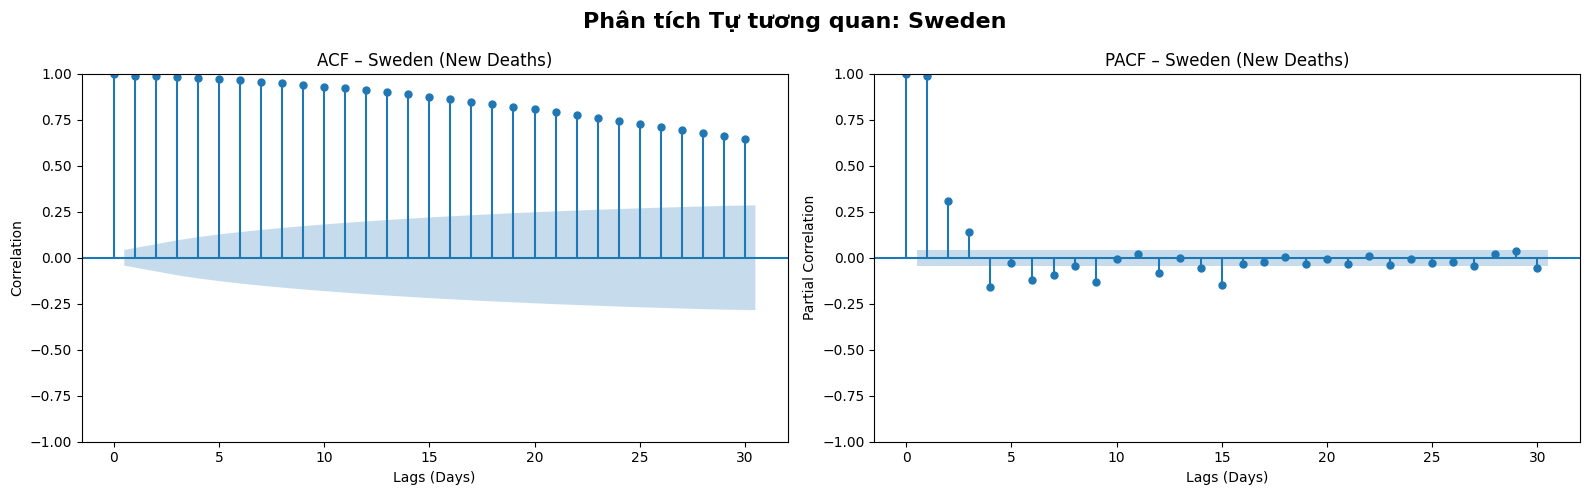

In [30]:
for c in rep_countries:
    
    sub = df_rep[df_rep["Country"] == c]["New_deaths"].fillna(0)
    
    # Kiểm tra nếu dữ liệu quá ít thì bỏ qua để tránh lỗi
    if len(sub) < 30:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Vẽ ACF bên trái
    plot_acf(sub, lags=30, ax=axes[0], title=f"ACF – {c} (New Deaths)")
    axes[0].set_xlabel('Lags (Days)')
    axes[0].set_ylabel('Correlation')

    # Vẽ PACF bên phải
    plot_pacf(sub, lags=30, method="ywm", ax=axes[1], title=f"PACF – {c} (New Deaths)")
    axes[1].set_xlabel('Lags (Days)')
    axes[1].set_ylabel('Partial Correlation')

    plt.suptitle(f"Phân tích Tự tương quan: {c}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Lưu file
    filename = f"../results/charts/acf_pacf_deaths_{c.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

## 4.3.2 Phân tích Độ trễ Nhiễm - Tử vong (Cross-Correlation)

Phần này trả lời câu hỏi: "Sau khi số ca nhiễm tăng, bao lâu thì số ca tử vong tăng?" (Lag time).

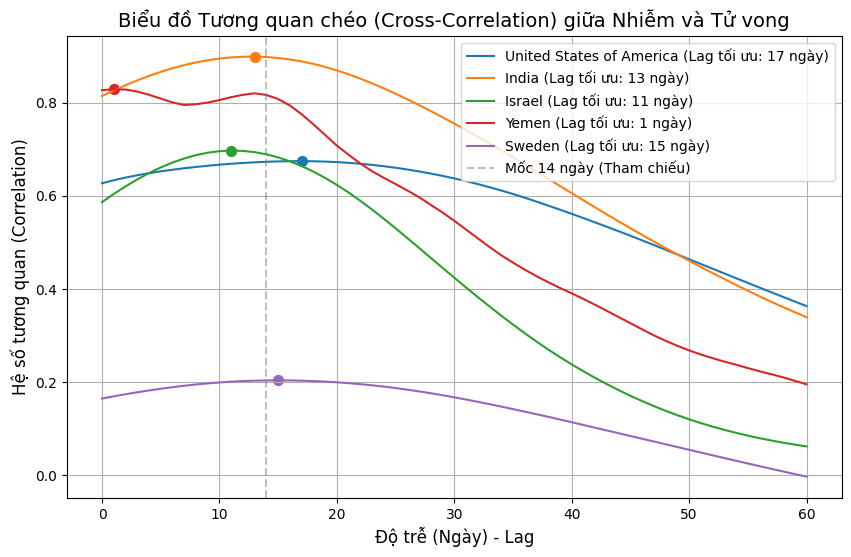

Độ trễ tối ưu (Optimal Lag) giữa đỉnh nhiễm và đỉnh tử vong: {'United States of America': 17, 'India': 13, 'Israel': 11, 'Yemen': 1, 'Sweden': 15}


In [8]:
def calculate_optimal_lag(df_country, country_name, max_lag=60):
    """
    Hàm tính tương quan chéo giữa Cases và Deaths khi dịch chuyển Deaths về sau 0-60 ngày
    """
    cases = df_country['New_cases_MA7'].fillna(0)
    deaths = df_country['New_deaths_MA7'].fillna(0)
    
    correlations = []
    lags = range(max_lag + 1)
    
    for lag in lags:
        # Shift deaths ngược lại (nghĩa là deaths xảy ra sau cases)
        # Tương quan giữa Cases(t) và Deaths(t + lag)
        shifted_deaths = deaths.shift(-lag) 
        corr = cases.corr(shifted_deaths)
        correlations.append(corr)
        
    # Tìm lag có tương quan cao nhất
    optimal_lag = np.argmax(correlations)
    max_corr = np.max(correlations)
    
    return lags, correlations, optimal_lag, max_corr

# Vẽ biểu đồ CCF Plot
plt.figure(figsize=(10, 6))

lag_results = {}

for country in rep_countries:
    df_c = df_rep[df_rep['Country'] == country]
        
    lags, corrs, opt_lag, max_corr = calculate_optimal_lag(df_c, country)
    
    lag_results[country] = opt_lag
    
    plt.plot(lags, corrs, label=f'{country} (Lag tối ưu: {opt_lag} ngày)')
    # Đánh dấu điểm cao nhất
    plt.scatter(opt_lag, max_corr, s=50)

plt.title('Biểu đồ Tương quan chéo (Cross-Correlation) giữa Nhiễm và Tử vong', fontsize=14)
plt.xlabel('Độ trễ (Ngày) - Lag', fontsize=12)
plt.ylabel('Hệ số tương quan (Correlation)', fontsize=12)
plt.axvline(x=14, color='gray', linestyle='--', alpha=0.5, label='Mốc 14 ngày (Tham chiếu)')
plt.legend()
plt.grid(True)
plt.savefig("../results/charts/ccf_plot_cases_deaths.png")
plt.show()

print("Độ trễ tối ưu (Optimal Lag) giữa đỉnh nhiễm và đỉnh tử vong:", lag_results)

## 4.3.3 Trích xuất Đặc trưng cuối cùng (Feature Table)
Tổng hợp lại tất cả các chỉ số (cả tĩnh và động) vào một bảng duy nhất để làm đầu vào cho kết luận hoặc mô hình nâng cao.

In [12]:
df_1.columns

Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'New_deaths', 'Cumulative_cases', 'Cumulative_deaths', 'New_cases_MA7',
       'New_deaths_MA7', 'Growth_Rate'],
      dtype='object')

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
    
# 1. Sắp xếp dữ liệu để đảm bảo tính thời gian
df_1 = df_1.sort_values(by=['Country', 'Date_reported']).reset_index(drop=True)

# 2. Tạo biến Mục tiêu (Target) đã làm trơn: New_cases_MA7
# Lý do: Giảm nhiễu (noise) ngày cuối tuần để mô hình học xu hướng tốt hơn
df_1['New_cases_MA7'] = df_1.groupby('Country')['New_cases'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# --- NHÓM 1: BIẾN TRỄ (LAG FEATURES) ---
df_1['Lag_1'] = df_1.groupby('Country')['New_cases_MA7'].shift(1)

df_1['Lag_7'] = df_1.groupby('Country')['New_cases_MA7'].shift(7)

# --- NHÓM 2: THỐNG KÊ TRƯỢT (ROLLING WINDOW STATISTICS) ---

df_1['Rolling_Mean_7'] = df_1.groupby('Country')['New_cases_MA7'].shift(1).transform(lambda x: x.rolling(window=7).mean())

# Rolling Std (Độ biến động/Rủi ro) - Cực quan trọng để phát hiện bùng phát
df_1['Rolling_Std_7'] = df_1.groupby('Country')['New_cases_MA7'].shift(1).transform(lambda x: x.rolling(window=7).std())

# --- NHÓM 3: ĐỘNG LƯỢNG (MOMENTUM / SLOPE) ---
# Hàm tính hệ số góc (Slope) trên cửa sổ trượt 7 ngày
def calculate_slope(y):
    x = np.arange(len(y))
    if np.isnan(y).any(): return np.nan
    slope = np.polyfit(x, y, 1)[0]
    return slope

# Áp dụng tính Slope (Lưu ý: hơi tốn thời gian tính toán hơn các biến khác)
print("Đang tính toán Rolling Slope (có thể mất chút thời gian)...")
df_1['Rolling_Slope_7'] = df_1.groupby('Country')['New_cases_MA7'].shift(1).transform(
    lambda x: x.rolling(window=7).apply(calculate_slope, raw=True)
)

df_clean = df_1.dropna().reset_index(drop=True)
    
print(f"Kích thước dữ liệu gốc: {df_1.shape}")
print(f"Kích thước sau khi tạo đặc trưng và xóa NaN: {df_clean.shape}")
    

Đang tính toán Rolling Slope (có thể mất chút thời gian)...
Kích thước dữ liệu gốc: (502800, 16)
Kích thước sau khi tạo đặc trưng và xóa NaN: (499032, 16)


In [17]:
feature_corr = [
    'New_cases_MA7',
    'Lag_1',
    'Lag_7',
    'Rolling_Mean_7',
    'Rolling_Std_7',
    'Rolling_Slope_7'
]

df_clean[feature_corr].corr()

,New_cases_MA7,Lag_1,Lag_7,Rolling_Mean_7,Rolling_Std_7,Rolling_Slope_7
New_cases_MA7,1.000000,0.996711,0.870302,9.549816e-01,0.748566,2.816710e-01
Lag_1,0.996711,1.000000,0.899656,9.737367e-01,0.746693,2.239101e-01
Lag_7,0.870302,0.899656,1.000000,9.737367e-01,0.684775,-2.239116e-01
Rolling_Mean_7,0.954982,0.973737,0.973737,1.000000e+00,0.726230,-7.976250e-07
Rolling_Std_7,0.748566,0.746693,0.684775,7.262303e-01,1.000000,1.403801e-01
Rolling_Slope_7,0.281671,0.223910,-0.223912,-7.976250e-07,0.140380,1.000000e+00


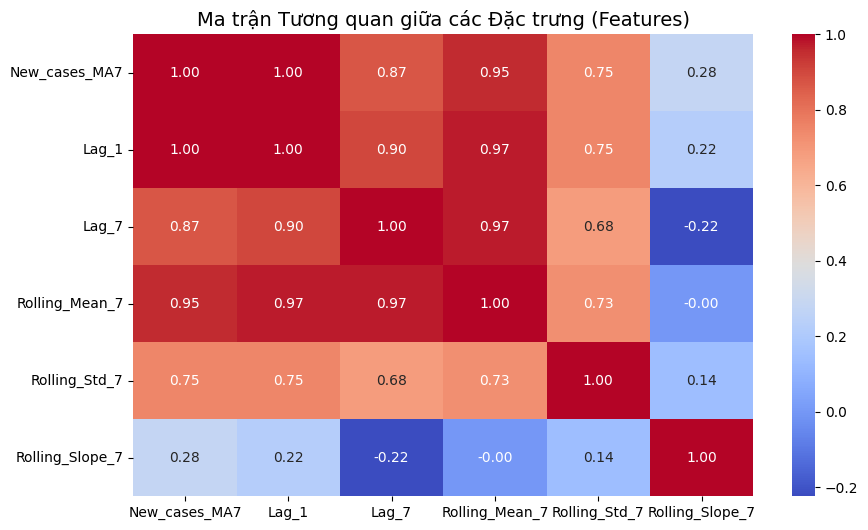

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[feature_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Ma trận Tương quan giữa các Đặc trưng (Features)', fontsize=14)
plt.savefig("../results/charts/feature_correlation_matrix.png")     
plt.show()
plt.close()

1. Tính Quán tính & Trí nhớ dài hạn (High Inertia)

* Số liệu: Lag_1 ($r \approx 0.997$) và Rolling_Mean ($r \approx 0.955$) có tương quan dương tuyệt đối với biến mục tiêu.

* Ý nghĩa: Dữ liệu có tính tự hồi quy mạnh. Quá khứ giải thích >95% hiện tại.

* Vai trò: Đóng vai trò "xương sống", giúp mô hình bám sát xu hướng chính.

2. Giá trị của "Sự khác biệt": Biến Hệ số góc (Slope)

* Số liệu: Tương quan thấp ($r \approx 0.28$) và độc lập tuyến tính với Mean.

* Ý nghĩa: Cung cấp thông tin về Gia tốc và Hướng di chuyển (tăng tốc/giảm tốc) mà các biến Lag không có.

* Vai trò: Chìa khóa để các mô hình phi tuyến phát hiện điểm đảo chiều (Turning Points) và đỉnh dịch.

3. Chỉ báo Rủi ro (Volatility)

* Số liệu: Rolling_Std tương quan khá cao ($r \approx 0.75$).

* Ý nghĩa: Xác nhận hiện tượng phương sai thay đổi (Heteroscedasticity) - Số ca càng cao, biến động càng lớn.

$\Rightarrow$ Kết luận: Bộ đặc trưng có sự cân bằng giữa nhóm duy trì xu hướng (Lag, Mean) và nhóm phát hiện đột biến (Slope, Std).